In [1]:
import sys
import numpy
from time import time
from matplotlib import pyplot
from scipy.stats import norm
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [2]:
a = sys.path.append('/home/delimar/Documents/sources/')

In [18]:
from codes import grids, auxiliars, statistical, prism, plot, filtering, derivative, equivalentlayer

In [19]:
# Numero de pontos e shape do dado
nx, ny = 40, 40
area = (-5000., 5000., -5000., 5000.)
shape = (nx, ny)
xo, yo, zo = grids.regular_grid(area, shape, -100.)

# Teste de justificativa

In [20]:
# Define modelo e direcoes
dike = [-500., 500., -2500., 2500., 100., 5000.]
intensity = 2.
inc, dec, incs, decs = -35., 60., 0., 0. 

In [21]:
# Calcula a anomalia de campo total
tf = prism.prism_tf(xo, yo, zo, dike, intensity, inc, dec, incs, decs)

In [22]:
# Analise do dado
print 'Anomalia magnetica:'
_ = statistical.analysis(tf, 'nT')

Anomalia magnetica:
Minimum:    -547.3706 nT
Maximum:    348.9015 nT
Mean value: -7.5013 nT
Variation:  896.2721 nT


In [23]:
# Adicao de ruido
tf = auxiliars.noise_normal_dist(tf, 5., 0.1)

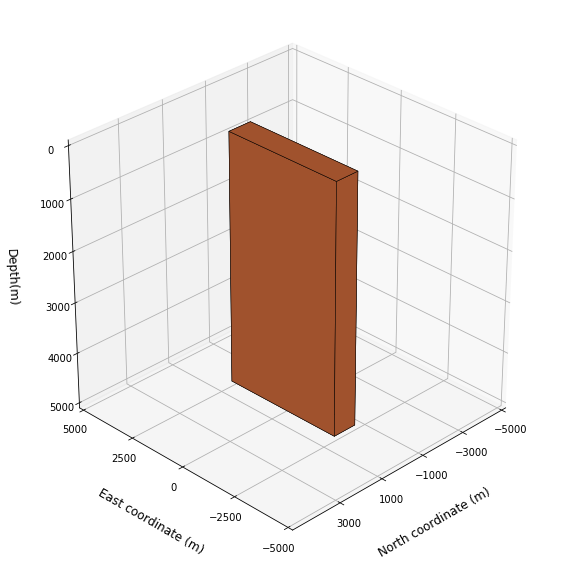

In [24]:
# Plota a figura do modelo sintetico
figure = pyplot.figure(figsize=(8,8))
ax = figure.gca(projection = '3d')

x1, x2, y1, y2, z1, z2 = dike[:6]
v = numpy.array([[x1, y1, z2], [x1, y2, z2], [x2, y2, z2], [x2, y1, z2], 
                 [x1, y1, z1], [x1, y2, z1], [x2, y2, z1], [x2, y1, z1]])
vertices = [[v[0],v[1],v[2],v[3]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]],
            [v[2],v[3],v[7],v[6]], [v[3],v[0],v[4],v[7]], [v[4],v[5],v[6],v[7]]]
ax.add_collection3d(Poly3DCollection(vertices, facecolors = 'sienna', linewidths = 0.5, 
                                     edgecolors = 'k', alpha = .1))
x_scale = 1.
y_scale = 1.
z_scale = 1.
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
ax.set_xlabel('North coordinate (m)', size = 12, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 12, labelpad = 20)
ax.set_zlabel('Depth(m)', size = 12, labelpad = 20)
ax.set_xlim(xo.min(), xo.max())
ax.set_ylim(yo.min(), yo.max())
ax.set_zlim(0., z2)
ax.set_xticks(numpy.arange(xo.min(), xo.max(), 2000))
ax.set_yticks(numpy.linspace(yo.min(), yo.max(), 5))
ax.set_zticks(numpy.linspace(0., z2, 6))
ax.view_init(210, 135)
pyplot.tight_layout(True)
pyplot.show()

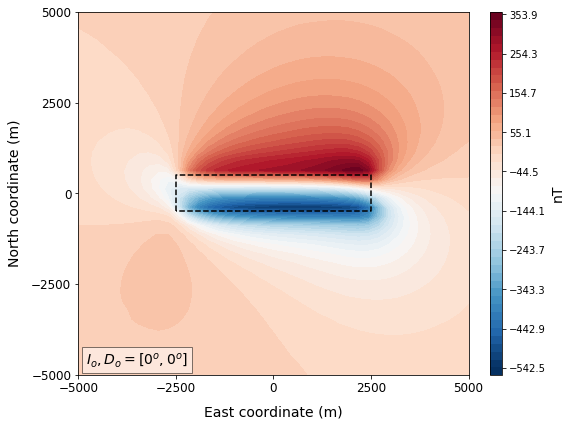

In [25]:
# Plota o resultado
pyplot.figure(figsize=(8,6))
cs = pyplot.contourf(yo.reshape(shape), xo.reshape(shape), tf.reshape(shape), 
                50, cmap = pyplot.cm.RdBu_r)
plot.draw_prism(dike[:4], linewidth = 0.25, style = 'k--', xy2ne = True)
pyplot.text(-4800., -4700., '$I_o, D_o = [0^o, 0^o]$', 
            fontsize = 14.,bbox=dict(facecolor='white', edgecolor='k', alpha = 0.5))
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)
cb = pyplot.colorbar(cs, aspect = 30, fraction = 0.04, orientation = 'vertical', pad = 0.05)
cb.set_ticks(numpy.linspace(tf.min(), tf.max(), 10))
cb.set_clim(tf.min(), tf.max())
cb.set_label('nT', fontsize = 14, labelpad = 5)
pyplot.tight_layout(True)
pyplot.show()

In [26]:
# Cria os grids de inclinacao
inclination = numpy.linspace(-90., 90., 181)
declination = numpy.linspace(-90., 90., 181)
D, I = numpy.meshgrid(declination, inclination)

In [27]:
# Cria a matriz de zeros
res = numpy.zeros_like(D)

In [28]:
# Reshape do dado
xobs = xo.reshape(shape)
yobs = yo.reshape(shape)
dobs = tf.reshape(shape)

In [29]:
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination):
        if i == 0. or d == 0.:
            rtp = filtering.reduction(xobs, yobs, dobs, inc, dec, i + 0.25, d + 0.25)
            res[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp), 
                                            derivative.zderiv(xobs, yobs, rtp)) 
        else:
            rtp = filtering.reduction(xobs, yobs, dobs, inc, dec, i, d)
            res[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp), 
                                            derivative.zderiv(xobs, yobs, rtp))        
final = time()
print 'Tempo de calculo (sec): %.3f' % (final-initial)

Tempo de calculo (sec): 59.092


In [30]:
print 'Maxima correlacao:', res.max()
print 'Minima correlacao:', res.min()

Maxima correlacao: 0.575602667832
Minima correlacao: -0.401431329712


In [31]:
imax, jmax = numpy.where(res == res.max())
imin, jmin = numpy.where(res == res.min())
incmax = float(I[imax, jmax])
decmax = float(D[imax, jmax])
incmin = float(I[imin, jmin])
decmin = float(D[imin, jmin])
print '(I,D) maximo:', incmax, decmax

(I,D) maximo: 0.0 84.0


/home/delimar/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


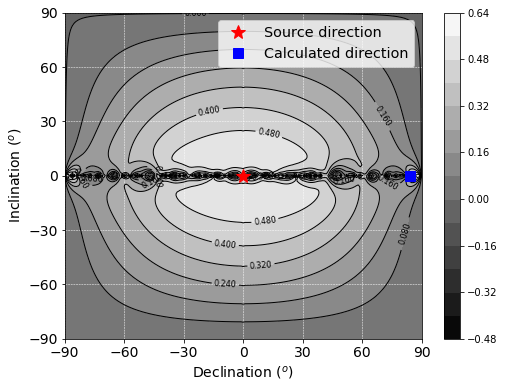

In [32]:
# Plota o mapa de correlacao
pyplot.figure(figsize=(8, 6))
fig = pyplot.contour(D, I, res, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D, I, res, 15, cmap = pyplot.cm.gray, alpha = 1.)
pyplot.clabel(fig, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 15)
pyplot.plot(decmax, incmax, 'bs', label = 'Calculated direction', markersize = 10)
#pyplot.title('Coeficientes de correlacao cruzada', fontsize = 16)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(D.min(), D.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(I.min(), I.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper right', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'w', linestyle='--', linewidth = .5)
pyplot.show()

In [33]:
# Calculo da reducao ao Polo
rtp = filtering.reduction(xo.reshape(shape), yo.reshape(shape), tf.reshape(shape), inc, dec, incmax, decmax)

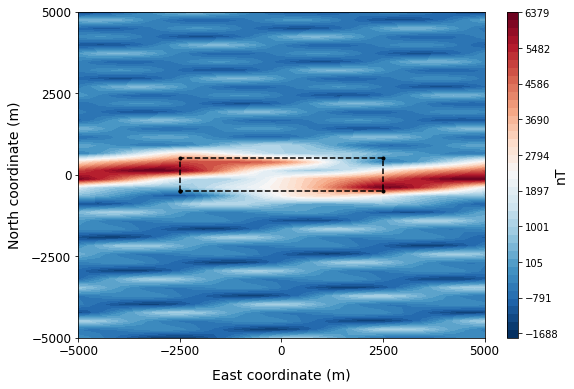

In [34]:
# Plota o resultado
pyplot.figure(figsize=(8, 6))
cs = pyplot.contourf(yo.reshape(shape), xo.reshape(shape), rtp,
                50, cmap = pyplot.cm.RdBu_r)
# Contorno do modelo
plot.draw_prism(dike[:4], linewidth=1., style = 'k.--' , xy2ne = True)
#pyplot.title('Anomalia magnetica reduzida ao Polo (nT)', fontsize = 16)
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)

cb = pyplot.colorbar(cs, aspect = 30, fraction = 0.04, orientation = 'vertical', pad = 0.05)
cb.set_ticks(numpy.linspace(rtp.min(), rtp.max(), 10))
cb.set_clim(rtp.min(), rtp.max())
cb.set_label('nT', fontsize = 14, labelpad = -5)
pyplot.show()

Somente para o intervalo de baixa latitude

In [35]:
# Novo grid de inclinacao e declinacao
inclow = numpy.linspace(-15., 15., 81)
declow = numpy.linspace(-90., 90., 181)
Dlow, Ilow = numpy.meshgrid(declow, inclow)

In [36]:
# Cria a matriz de zeros
reslow = numpy.zeros_like(Dlow)

In [37]:
# Primeira correlacao para o teste 1
initial = time()
for k2, d in enumerate(declow):
    for k1, i in enumerate(inclow):
        if i == 0. or d == 0.:
            rtp = filtering.reduction(xobs, yobs, dobs, inc, dec, i + 0.25, d + 0.25)
            reslow[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp), 
                                               derivative.zderiv(xobs, yobs, rtp)) 
        else:
            rtp = filtering.reduction(xobs, yobs, dobs, inc, dec, i, d)
            reslow[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp), 
                                               derivative.zderiv(xobs, yobs, rtp))        
final = time()
print 'Tempo de calculo (sec): %.3f' % (final-initial)

Tempo de calculo (sec): 28.365


In [38]:
print 'Maxima correlacao:', reslow.max()
print 'Minima correlacao:', reslow.min()

Maxima correlacao: 0.575602667832
Minima correlacao: -0.401431329712


In [39]:
ilow, jlow = numpy.where(reslow == reslow.max())
imaxlow = float(Ilow[ilow, jlow])
dmaxlow = float(Dlow[ilow, jlow])
print '(I,D) maximo:', imaxlow, dmaxlow

(I,D) maximo: 0.0 84.0


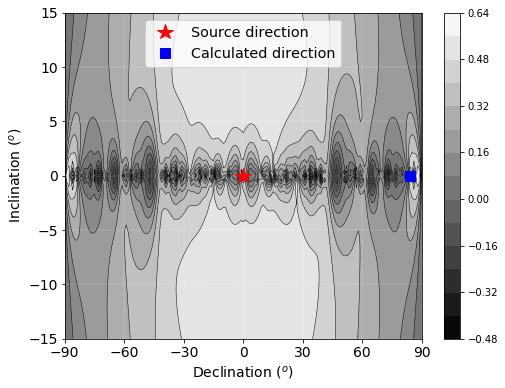

In [40]:
# Plota o mapa de correlacao
pyplot.figure(figsize=(8, 6))
fig = pyplot.contour(Dlow, Ilow, reslow, 15, colors = 'k', linestyle = 'solid', linewidths = 0.5)
pyplot.contourf(Dlow, Ilow, reslow, 15, cmap = pyplot.cm.gray, alpha = 1.)
#pyplot.clabel(fig, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 16)
pyplot.plot(dmaxlow, imaxlow, 'bs', label = 'Calculated direction', markersize = 10)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(Dlow.min(), Dlow.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Ilow.min(), Ilow.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'w', linestyle='--', linewidth = .25)
pyplot.show()

In [41]:
# Calculo da reducao ao Polo
rtplow = filtering.reduction(xo.reshape(shape), yo.reshape(shape), tf.reshape(shape), inc, dec, imaxlow, dmaxlow)

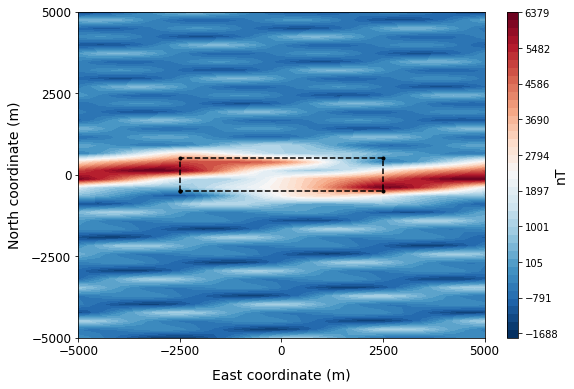

In [43]:
# Plota o resultado
pyplot.figure(figsize=(8, 6))
cs = pyplot.contourf(yo.reshape(shape), xo.reshape(shape), rtplow,
                50, cmap = pyplot.cm.RdBu_r)
# Contorno do modelo
plot.draw_prism(dike[:4], linewidth=1., style = 'k.--' , xy2ne = True)
#pyplot.title('Anomalia magnetica reduzida ao Polo (nT)', fontsize = 16)
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)

cb = pyplot.colorbar(cs, aspect = 30, fraction = 0.04, orientation = 'vertical', pad = 0.05)
cb.set_ticks(numpy.linspace(rtplow.min(), rtplow.max(), 10))
cb.set_clim(rtplow.min(), rtplow.max())
cb.set_label('nT', fontsize = 14, labelpad = -5)
pyplot.show()

## Using the equivalent layer

Teste para convergência

In [44]:
import time
inicial = time.time()
shapes = numpy.arange(10, 50 + 1, 1)
area_layer = area
level = 1200.
data = [xo, yo, zo, tf]
residuo = numpy.zeros_like(shapes)
tempo = []

for i in range(shapes.size):
    ii = time.time()
    camada = equivalentlayer.layer(area_layer, (shapes[i], shapes[i]), level)
    _, pp = equivalentlayer.fit_layer(data, shape, camada, (shapes[i], shapes[i]), 0.001, inc, dec, incs, decs)
    residuo[i] = numpy.sum((tf - pp)**2)
    #residuo[i] = (tf - pp).mean()
    ff = time.time()
tempo.append(ff - ii)
print time.time() - inicial

74.699450016


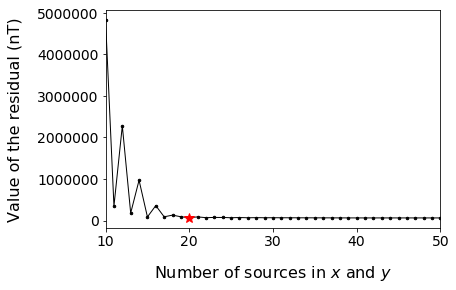

In [46]:
pyplot.figure(figsize=(6, 4))
pyplot.plot(shapes, residuo, 'k-', linewidth = 1.)
pyplot.plot(shapes, residuo, 'ko', markersize = 2.5)
pyplot.plot(shapes[10], residuo[10], 'r*', markersize = 10.)
pyplot.xlabel('Number of sources in $x$ and $y$', fontsize = 16, labelpad = 15)
pyplot.ylabel('Value of the residual (nT)', fontsize = 16, labelpad = 15)
pyplot.xticks(numpy.linspace(shapes.min(), shapes.max(), 5), fontsize = 14)
pyplot.xlim(shapes.min(), shapes.max())
pyplot.yticks(fontsize = 14)
pyplot.show()

Construcao da camada equivalente

In [47]:
# Construindo uma camada equivalente
area_layer = area
shape_layer = (15, 15)
level = 1200.

In [48]:
# Para plot:
xlayer, ylayer, zlayer = grids.regular_grid(area, shape_layer, level)

In [49]:
# Calcula a camada equivalente
eqlayer = equivalentlayer.layer(area_layer, shape_layer, level)

In [50]:
# Aloca todos os valores em uma lista
data = [xo, yo, zo, tf]

In [51]:
# Calcula o dado predito}
_, tf_pred = equivalentlayer.fit_layer(data, shape, eqlayer, shape_layer, 0.0000001, inc, dec, incs, decs)

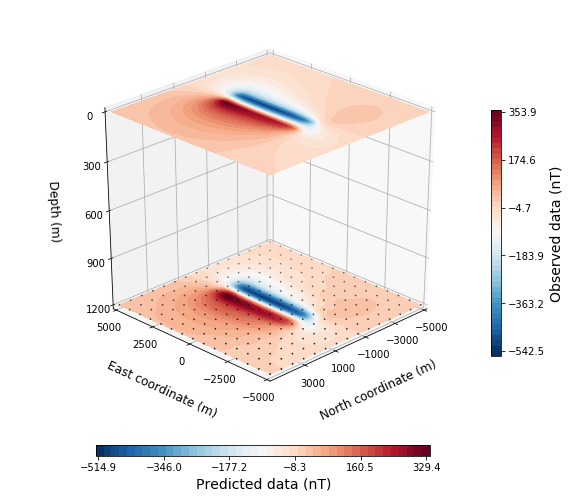

In [52]:
# Plota a figura do modelo sintetico
figure = pyplot.figure(figsize=(8,7))
ax = figure.gca(projection = '3d')
p1 = ax.contourf(xo.reshape(shape), yo.reshape(shape), tf.reshape(shape),
                 50, zdir='z', offset = 0., cmap = 'RdBu_r',
                  vmin = numpy.min(tf), vmax = numpy.max(tf))
cbar1 = pyplot.colorbar(p1, aspect = 25, fraction = 0.02, orientation = 'vertical', pad = -0.05)
cbar1.set_label('Observed data (nT)', fontsize = 14, rotation = 90.)
cbar1.set_ticks(numpy.linspace(tf.min(), tf.max(), 6))

p2 = ax.contourf(xo.reshape(shape), yo.reshape(shape), tf_pred.reshape(shape),
                 50, zdir='z', offset = level, cmap = 'RdBu_r',
                  vmin = numpy.min(tf_pred), vmax = numpy.max(tf_pred))
ax.scatter3D(xlayer.reshape(shape_layer), ylayer.reshape(shape_layer), zlayer.reshape(shape_layer), 
             s = 0.5, c = 'k')
cbar2 = pyplot.colorbar(p2, aspect = 30, fraction = 0.025, orientation = 'horizontal', pad = 0.05)
cbar2.set_label('Predicted data (nT)', fontsize = 14, rotation = 0.)
cbar2.set_ticks(numpy.linspace(tf_pred.min(), tf_pred.max(), 6))

x_scale = 1.
y_scale = 1.
z_scale = 1.25
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
ax.set_xlabel('North coordinate (m)', size = 12, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 12, labelpad = 20)
ax.set_zlabel('Depth (m)', size = 12, labelpad = 20)
ax.set_xlim(xo.min(), xo.max())
ax.set_xticks(numpy.arange(xo.min(), xo.max(), 2000.))
ax.set_yticks(numpy.linspace(yo.min(), yo.max(), 5))
ax.set_zticks(numpy.linspace(0., level, 5))
ax.set_ylim(yo.min(), yo.max())
ax.set_zlim(0., level)
ax.view_init(210, 135)
pyplot.tight_layout(True)
pyplot.show()

In [53]:
residuo = tf - tf_pred

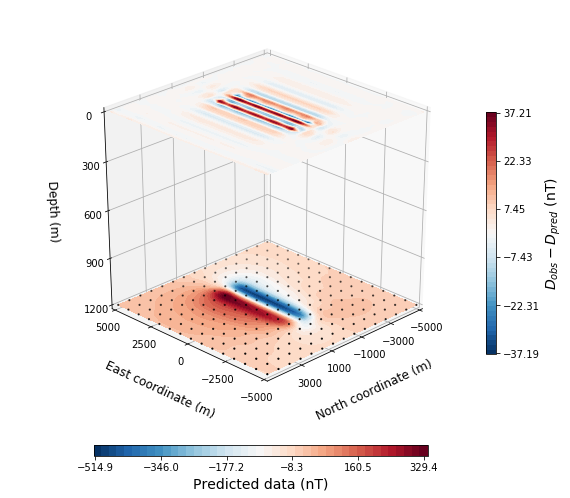

In [54]:
# Plota a figura do modelo sintetico
figure = pyplot.figure(figsize=(8,7))
ax = figure.gca(projection = '3d')
#ax.set_title('Ajuste de dados via camada equivalente', size = 16, pad = 10)
p1 = ax.contourf(xo.reshape(shape), yo.reshape(shape), residuo.reshape(shape),
                 50, zdir='z', offset = 0., cmap = 'RdBu_r',
                  vmin = numpy.min(residuo), vmax = numpy.max(residuo))
cbar1 = pyplot.colorbar(p1, aspect = 25, fraction = 0.02, orientation = 'vertical', pad = -0.05)
cbar1.set_label('$D_{obs} - D_{pred}$ (nT)', fontsize = 14, rotation = 90.)
cbar1.set_ticks(numpy.linspace(residuo.min(), residuo.max(), 6))

p2 = ax.contourf(xo.reshape(shape), yo.reshape(shape), tf_pred.reshape(shape),
                 50, zdir='z', offset = level, cmap = 'RdBu_r',
                  vmin = numpy.min(tf_pred), vmax = numpy.max(tf_pred))
ax.scatter3D(xlayer.reshape(shape_layer), ylayer.reshape(shape_layer), zlayer.reshape(shape_layer), 
             s = 1.5, c = 'k')
cbar2 = pyplot.colorbar(p2, aspect = 30, fraction = 0.025, orientation = 'horizontal', pad = 0.05)
cbar2.set_label('Predicted data (nT)', fontsize = 14, rotation = 0.)
cbar2.set_ticks(numpy.linspace(tf_pred.min(), tf_pred.max(), 6))

x_scale = 1.
y_scale = 1.
z_scale = 1.25
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
ax.set_xlabel('North coordinate (m)', size = 12, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 12, labelpad = 20)
ax.set_zlabel('Depth (m)', size = 12, labelpad = 20)
ax.set_xlim(xo.min(), xo.max())
ax.set_xticks(numpy.arange(xo.min(), xo.max(), 2000.))
ax.set_yticks(numpy.linspace(yo.min(), yo.max(), 5))
ax.set_zticks(numpy.linspace(0., level, 5))
ax.set_ylim(yo.min(), yo.max())
ax.set_zlim(0., level)
ax.view_init(210, 135)
pyplot.tight_layout(True)

pyplot.show()

In [56]:
res_mu = numpy.mean(residuo)
res_sigma = numpy.std(residuo)

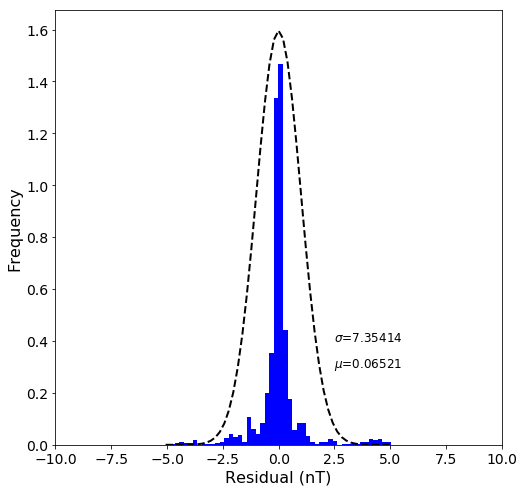

In [60]:
pyplot.figure(figsize=(8,8))
s = (residuo - res_mu) / res_sigma
s = numpy.ravel(s)
nbins = int(numpy.max(s) - numpy.min(s))
n, bins, patches = pyplot.hist(s, 50, normed = True, facecolor = 'blue', alpha = 1.)
y_hist = norm.pdf(bins, numpy.mean(s), numpy.std(s))
pyplot.plot(bins, 4*y_hist, 'k--', linewidth = 2)
pyplot.text(4,0.3, '$\mu$=%0.5f' % (res_mu), horizontalalignment = 'center', fontsize = 12)
pyplot.text(4,0.4, '$\sigma$=%0.5f' % (res_sigma), horizontalalignment = 'center', fontsize = 12)
pyplot.xlabel('Residual (nT)' , fontsize = 16)
pyplot.ylabel('Frequency', fontsize = 16)
pyplot.xlim(-10,10)
pyplot.xticks(fontsize = 14)
pyplot.yticks(fontsize = 14)
#pyplot.savefig('cap04a-histograma.png', dpi = 300, bbox_inches = 'tight', transparent = True)
#pyplot.savefig('cap04a-histograma.pdf', dpi = 300, bbox_inches = 'tight', transparent = True)
pyplot.show()

In [61]:
# Novo grid de inclinacao e declinacao
incfull = numpy.linspace(-90., 90., 37)
decfull = numpy.linspace(-90., 90., 13)
Dfull, Ifull = numpy.meshgrid(decfull, incfull)

In [62]:
# Cria a matriz de zeros
resfull = numpy.zeros_like(Dfull)

In [64]:
# Computando a correlação utilizando somente camada equivalente
ii = time.time()
for k2, d in enumerate(decfull):
    for k1, i in enumerate(incfull):
        if i >= -15. or i <= 15.:
            rtp = equivalentlayer.rtp_layer(data, shape, eqlayer, shape_layer, 0.01, inc, dec, i, d)
            resfull[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp.reshape(shape)),
                                                derivative.zderiv(xobs, yobs, rtp.reshape(shape)))    
        else:
            rtp = filtering.reduction(xobs, yobs, dobs, inc, dec, i, d)
            resfull[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp),
                                                derivative.zderiv(xobs, yobs, rtp))            
ff = time.time()
print 'Tempo de calculo (sec): %.3f' % (ff-ii)

Tempo de calculo (sec): 344.499


In [65]:
print 'Maxima correlacao:', resfull.max()
print 'Minima correlacao:', resfull.min()

Maxima correlacao: 0.673595664387
Minima correlacao: -0.0498587020166


In [66]:
imaxfull, jmaxfull = numpy.where(resfull == resfull.max())
incmaxfull = float(Ifull[imaxfull, jmaxfull])
decmaxfull = float(Dfull[imaxfull, jmaxfull])
print '(I,D) maximo:', incmaxfull, decmaxfull

(I,D) maximo: 0.0 0.0


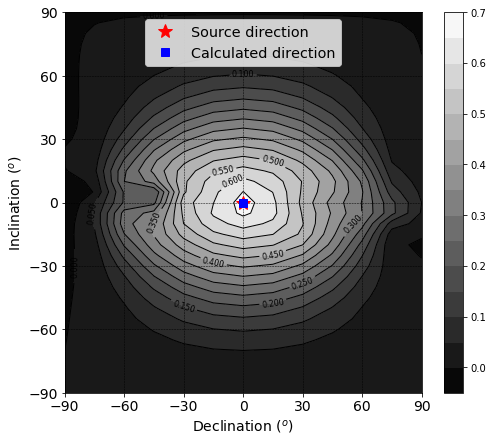

In [67]:
# Plota o mapa de correlacao
pyplot.figure(figsize=(8, 7))
fig5c = pyplot.contour(Dfull, Ifull, resfull, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(Dfull, Ifull, resfull, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig5c, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 15)
pyplot.plot(decmaxfull, incmaxfull, 'bs', label = 'Calculated direction', markersize = 8)
#pyplot.title('Coeficientes de correlacao cruzada', fontsize = 16)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(Dfull.min(), Dfull.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Ifull.min(), Ifull.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'k', linestyle='--', linewidth = .5)
pyplot.show()

In [69]:
areai = (-90., 90., -90., 90)
shapei = (181, 181)
Inci, Deci = grids.regular_grid(areai, shapei)

In [70]:
datares = resfull.reshape(resfull.size)

In [71]:
datai = griddata((Ifull.reshape(Ifull.size), Dfull.reshape(Dfull.size)), 
                 datares, (Inci, Deci), method = 'cubic')
datai = datai.reshape(shapei)

In [72]:
imaxi, jmaxi = numpy.where(datai == datai.max())
inci = float(Inci.reshape(shapei)[imaxi, jmaxi])
deci = float(Deci.reshape(shapei)[imaxi, jmaxi])
print '(I,D) maximo:', inci, deci

(I,D) maximo: -1.0 2.0


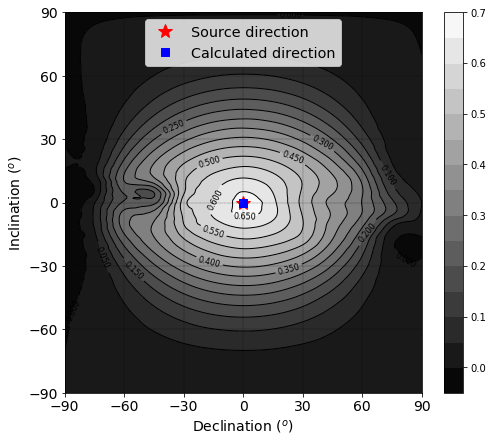

In [74]:
# Plota o mapa de correlacao
pyplot.figure(figsize=(8, 7))
fig5c = pyplot.contour(Deci.reshape(shapei), Inci.reshape(shapei), datai, 15, 
                       colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(Deci.reshape(shapei), Inci.reshape(shapei), datai, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig5c, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 15)
pyplot.plot(decmaxfull, incmaxfull, 'bs', label = 'Calculated direction', markersize = 8)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(Deci.min(), Deci.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Inci.min(), Inci.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'k', linestyle='--', linewidth = .25)
pyplot.show()

In [75]:
# Novo grid de inclinacao e declinacao
inclayer = numpy.linspace(-15., 15., 31)
declayer = numpy.linspace(-90., 90., 19)
Dlayer, Ilayer= numpy.meshgrid(declayer, inclayer)

In [76]:
# Cria a matriz de zeros
reslayer = numpy.zeros_like(Dlayer)

In [77]:
# Computando a correlação utilizando somente camada equivalente
#initial = time()
for k2, d in enumerate(declayer):
    for k1, i in enumerate(inclayer):
        rtp = equivalentlayer.rtp_layer(data, shape, eqlayer, shape_layer, 0.01, inc, dec, i, d)
        reslayer[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp.reshape(shape)), 
                                             derivative.zderiv(xobs, yobs, rtp.reshape(shape)))    
#final = time()
#print 'Tempo de calculo (sec): %.3f' % (final-initial)

In [78]:
print 'Maxima correlacao:', reslayer.max()
print 'Minima correlacao:', reslayer.min()

Maxima correlacao: 0.674376053919
Minima correlacao: -0.0804002804351


In [79]:
imaxlayer, jmaxlayer = numpy.where(reslayer == reslayer.max())
incmaxlayer = float(Ilayer[imaxlayer, jmaxlayer])
decmaxlayer = float(Dlayer[imaxlayer, jmaxlayer])
print '(I,D) maximo:', incmaxlayer, decmaxlayer

(I,D) maximo: -1.0 0.0


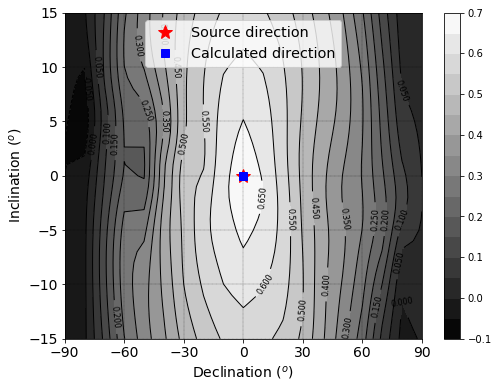

In [80]:
# Plota o mapa de correlacao
pyplot.figure(figsize=(8, 6))
fig5c = pyplot.contour(Dlayer, Ilayer, reslayer, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(Dlayer, Ilayer, reslayer, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig5c, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 15)
pyplot.plot(decmaxlayer, incmaxlayer+1, 'bs', label = 'Calculated direction', markersize = 8)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(Dlayer.min(), Dlayer.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Ilayer.min(), Ilayer.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'k', linestyle='--', linewidth = .25)
pyplot.show()

In [81]:
# Calculando a reducao ao polo em baixa latitude
rtp_final = equivalentlayer.rtp_layer(data, shape, eqlayer, shape_layer, 0., inc, dec, incmaxfull, decmaxfull)

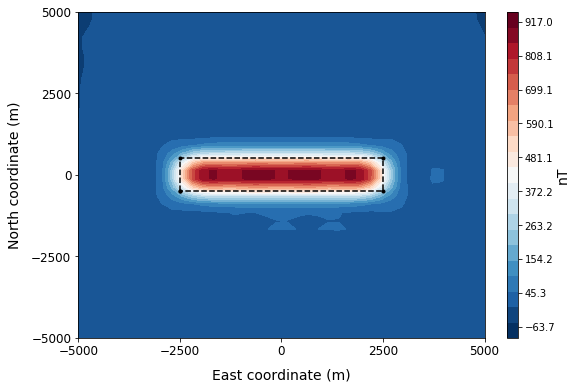

In [82]:
# Plota o resultado
pyplot.figure(figsize=(8,6))
cs = pyplot.contourf(yo.reshape(shape), xo.reshape(shape), rtp_final.reshape(shape), 
                     20, cmap = pyplot.cm.RdBu_r)
plot.draw_prism(dike[:4], linewidth=1., style = 'k.--' , xy2ne = True)
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)

cb = pyplot.colorbar(cs, aspect = 30, fraction = 0.04, orientation = 'vertical', pad = 0.05)
cb.set_ticks(numpy.linspace(rtp_final.min(), rtp_final.max(), 10))
cb.set_clim(rtp_final.min(), rtp_final.max())
cb.set_label('nT', fontsize = 14, labelpad = 0.)
pyplot.show()